# Application: Exothermic Continuous Stirred Tank Reactor

## Description

This example is intended as an introduction to the nonlinear dynamics of an exothermic continuous stirred-tank reactor. The example has been studied by countless researchers and students since the pioneering work of Amundson and Aris in the 1950's. The particular formulation and parameter values described below are taken from example 2.5 from Seborg, Edgar, Mellichamp and Doyle (SEMD).

![Exothermic Reactor](https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Agitated_vessel.svg/500px-Agitated_vessel.svg.png)

(Diagram By [Daniele Pugliesi](https://commons.wikimedia.org/wiki/User:Daniele_Pugliesi) - Own work, [CC BY-SA 3.0](http://creativecommons.org/licenses/by-sa/3.0), [Link](https://commons.wikimedia.org/w/index.php?curid=6915706))

## Reaction Kinetics

We assume the kinetics are dominated by a single first order reaction

$$A \xrightarrow{kc_A}{} \text{Products}$$

The reaction rate per unit volume is modeled as the product $kc_A$ where $c_A$ is the concentration of $A$. The rate constant $k(T)$ is a increases with temperature following the Arrehenius law

$$k(T) = k_0 e^{-\frac{E_a}{RT}}$$

$E_a$ is the activation energy, $R$ is the gas constant, $T$ is absolute temperature, and $k_0$ is the pre-exponential factor.

We can see the strong temperature dependence by plotting $k(T)$ versus temperature over typical operating conditions.

<Axes: xlabel='Absolute Temperature [K]'>

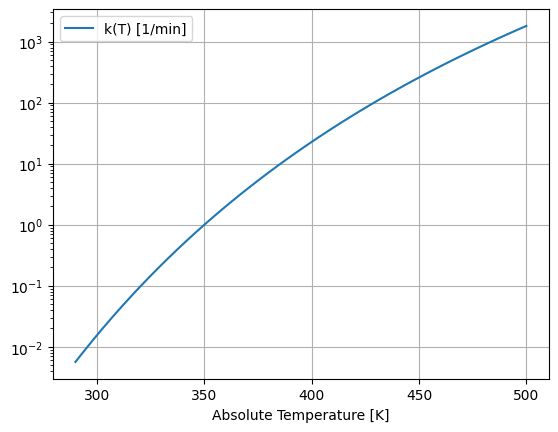

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns

# Arrehnius parameters
Ea = 72750     # activation energy J/gmol
R = 8.314      # gas constant J/gmol/K
k0 = 7.2e10    # Arrhenius rate constant 1/min

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/(R*T))

T = np.linspace(290, 500)
df = pd.DataFrame({"Absolute Temperature [K]": T, "k(T) [1/min]": k(T)})
df.plot(x=0, y=1, logy=True, grid=True)

This graph shows the reaction rate changes by six orders of magnitude over the range of possible operating temperatures. Because an exothermic reaction releases heat faster at higher temperatures, there is a positive feedback that can potentially result in unstable process behavior.

## Model Equations and Parameter Values

The model consists of mole and energy balances on the contents of the well-mixed reactor.

\begin{align*}
V\frac{dc_A}{dt} & = q(c_{A,f} - c_A) - Vk(T)c_A \\
\rho C_p V\frac{dT}{dt} & = \rho  C_p q(T_f - T) + (-\Delta H_R)Vk(T)c_A + UA(T_c - T)
\end{align*}

Normalizing the equations to isolate the time rates of change of $c_A$ and $T$ give

\begin{align*}
\frac{dc_A}{dt} & = \frac{q}{V}(c_{A,f} - c_A)- k(T)c_A \\
\frac{dT}{dt} & = \frac{q}{V}(T_f - T) + \frac{-\Delta H_R}{\rho C_p}k(T)c_A + \frac{UA}{V\rho C_p}(T_c - T)
\end{align*}

which are the equations that will be integrated below.

| Quantity | Symbol | Value | Units | Comments |
| :------- | :----: | :---: | :---- | :--- |
| Activation Energy | $E_a$ | 72,750 | J/gmol | |
| Arrehnius pre-exponential | $k_0$ | 7.2 x 10<sup>10</sup> | 1/min | |
| Gas Constant | $R$ | 8.314 | J/gmol/K | |
| Reactor Volume | $V$ | 100 | liters | |
| Density | $\rho$ | 1000 | g/liter | |
| Heat Capacity | $C_p$ | 0.239 | J/g/K | |
| Enthalpy of Reaction | $\Delta H_r$ | -50,000 | J/gmol | |
| Heat Transfer Coefficient | $UA$ | 50,000 | J/min/K | |
| Feed flowrate | $q$ | 100 | liters/min | |
| Feed concentration | $c_{A,f}$ | 1.0 | gmol/liter | |
| Feed temperature | $T_f$ | 350 | K | |
| Coolant temperature | $T_c$ | 300 | K | Manipulated Variable |
| Initial concentration | $c_{A,0}$ | 0.5 | gmol/liter | |
| Initial temperature | $T_0$ | 350 | K | |



This mathematical formulation is implemented as a function `simulate_cstr` that returns a `pandas` DataFrame object. The inputs to the function is a grid of points in time for the which a solution is required, initial conditions, and values for selected operating parameters. The remaining parameters are fixed in the body of the function. With this design, all calculations within the function require no access to parameters or function defined outside of `simulate_cstr`.

In [4]:
import pandas as pd
from scipy.integrate import solve_ivp

# study parameters
Tc  = 300.0     # Coolant temperature [K]
cA0 = 0.5;      # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]

def simulate_cstr(t_eval, Tc=Tc, cA0=cA0, T0=T0):

    # fixed model parameters
    Ea  = 72750     # activation energy J/gmol
    R   = 8.314     # gas constant J/gmol/K
    k0  = 7.2e10    # Arrhenius rate constant 1/min
    V   = 100.0     # Volume [L]
    rho = 1000.0    # Density [g/L]
    Cp  = 0.239     # Heat capacity [J/g/K]
    dHr = -5.0e4    # Enthalpy of reaction [J/mol]
    UA  = 5.0e4     # Heat transfer [J/min/K]
    q   = 100.0     # Flowrate [L/min]
    cAf = 1.0       # Inlet feed concentration [mol/L]
    Tf  = 350.0     # Inlet feed temperature [K]

    # Arrhenius rate expression
    def k(T):
        return k0*np.exp(-Ea/(R*T))

    # function to evaluate differential equations
    def deriv(t, y):
        cA, T = y
        dcAdt = (q/V)*(cAf - cA) - k(T)*cA
        dTdt = (q/V)*(Tf - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
        return [dcAdt, dTdt]

    # solve ivp
    soln = solve_ivp(deriv, [min(t_eval), max(t_eval)], [cA0, T0], t_eval=t_eval)

    # return solution as a pandas dataframe
    df = pd.DataFrame({"Time": t_eval})
    df["cA"] = soln.y[0, :]
    df["T"] = soln.y[1, :]
    return df

We first define a visualization function that will be reused in later simulations.

(318.68954619364376, 367.5)

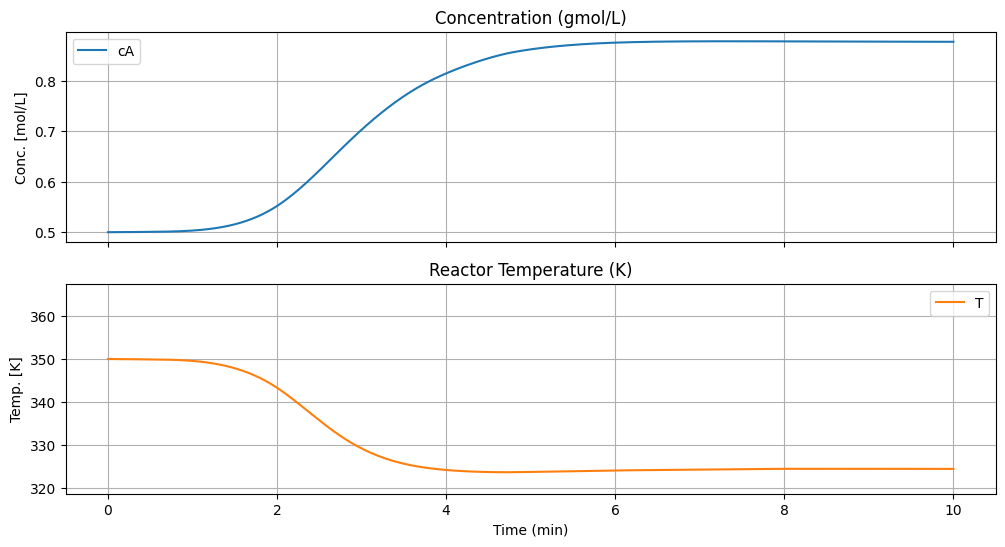

In [23]:
import numpy as np

# time grid
t_final = 10.0
t_eval = np.linspace(0, t_final, 1001)

# simulate for default cooling temperature and initial conditions
df = simulate_cstr(t_eval)

# Capture the axes array returned by .plot()
axes = df.plot(x="Time", xlabel="Time (min)", subplots=True,
    title=["Concentration (gmol/L)", "Reactor Temperature (K)"],
    figsize=(12, 6), sharex=True, grid=True)

# Set unique y-labels
axes[0].set_ylabel("Conc. [mol/L]")
axes[1].set_ylabel("Temp. [K]")

# Dynamically set ylim for temperature to capture the peak with a 5% buffer
T_max = df["T"].max()
T_min = df["T"].min()
axes[1].set_ylim(T_min - 5, T_max * 1.05)

## Effect of Cooling Temperature

The primary means of controlling the reactoris through temperature of the cooling water jacket. The next calculations explore the effect of plus or minus change of 5 K in cooling water temperature on reactor behavior. These simulations reproduce the behavior shown in Example 2.5 SEMD.

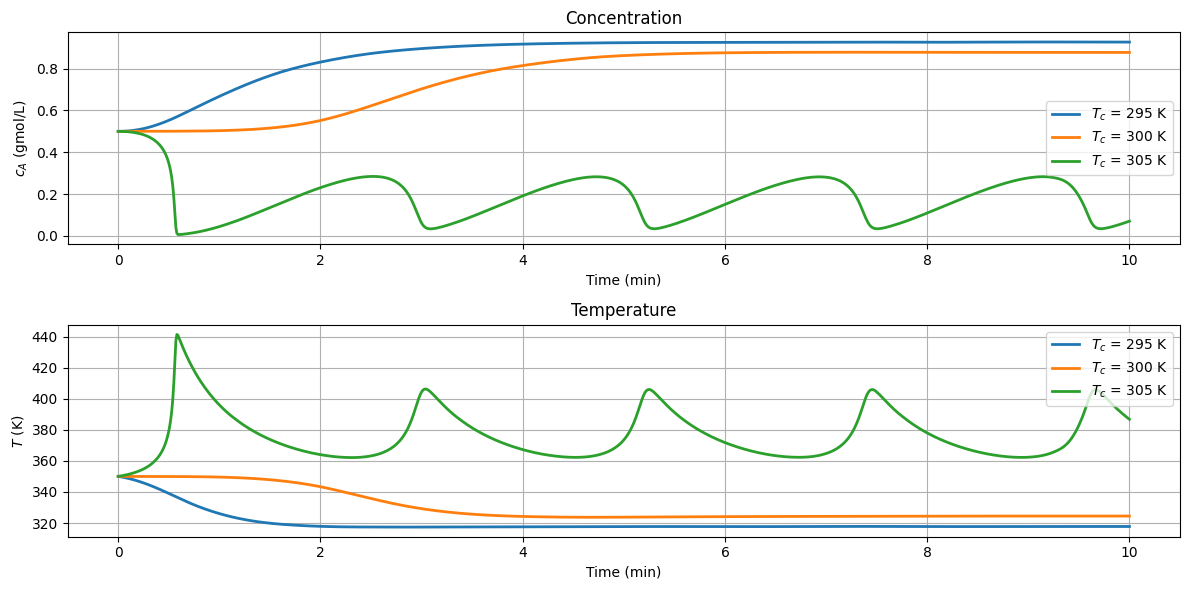

In [6]:
# create plot grid
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# simulate for a range of cooling temperatures
t_final = 10
t_eval = np.linspace(0, t_final, 1001)

for Tc in [295, 300, 305]:
    df = simulate_cstr(t_eval, Tc)
    df.plot(x="Time", xlabel="Time (min)", y="cA", ylabel="$c_A$ (gmol/L)",
            ax=ax[0], grid=True, title="Concentration", label=f"$T_c$ = {Tc} K", lw=2)
    df.plot(x="Time", xlabel="Time (min)", y="T", ylabel="$T$ (K)",
            ax=ax[1], grid=True, title="Temperature", label=f"$T_c$ = {Tc} K", lw=2)

fig.tight_layout()

## Interactive Simulation

Executing the following cell provides an interactive tool for exploring the relationship of cooling temperature with reactor behavior.  Use it to observe a thermal runaway, sustained osciallations, and low and high conversion steady states.

interactive(children=(FloatSlider(value=300.0, description='T_cooling', max=310.0, min=290.0), FloatSlider(val…

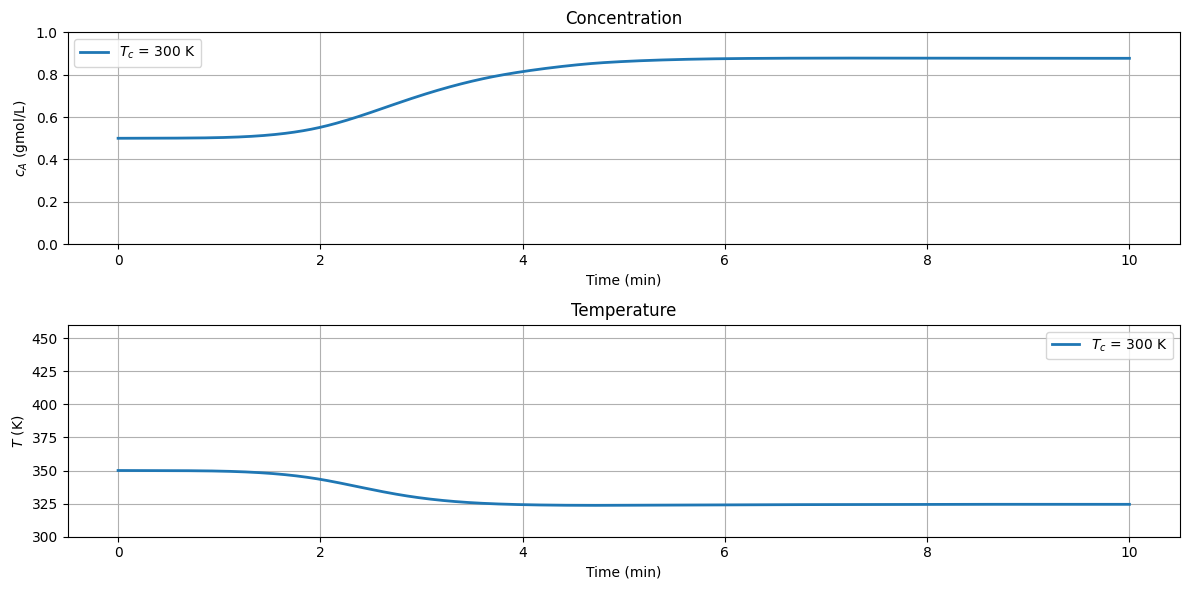

In [24]:
import matplotlib.pyplot as plt

# Install and uncomment these two packages to run the interactive widget
from ipywidgets import interact
from IPython.display import display

# initial simulation
t_final = 10.0
t_eval = np.linspace(0, t_final, 1001)
df = simulate_cstr(t_eval)

# plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
df.plot(x="Time", y="cA", xlabel="Time (min)", ylabel="$c_A$ (gmol/L)",
        ax=ax[0], ylim=(0, 1), grid=True, title="Concentration", lw=2)
df.plot(x="Time", y="T", xlabel="Time (min)", ylabel="$T$ (K)",
        ax=ax[1], ylim=(300, 460), grid=True, title="Temperature", lw=2)
fig.tight_layout()

# this close is needed to avoid duplicate plotter output
plt.close(fig)

# function to update and display the plot object
def sim(T_cooling, c_initial, T_initial):
    df = simulate_cstr(t_eval, T_cooling, c_initial, T_initial)
    ax[0].lines[0].set_ydata(df["cA"])
    ax[0].legend().get_texts()[0].set_text("$T_c$ = "+str(T_cooling)+" K")
    ax[1].lines[0].set_ydata(df["T"])
    ax[1].legend().get_texts()[0].set_text("$T_c$ = "+str(T_cooling)+" K")
    display(fig)

# uncomment the line below to run the interactive widget
interact(sim, T_cooling = (290.0, 310.0), c_initial = (0.0, 1.0, 0.01), T_initial = (300, 400));

sim(T_cooling=300, c_initial=0.5, T_initial=350)


In [26]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np

def interactive_nullclines(Tc=300.0):
    fig, ax = plt.subplots(figsize=(10, 8))

    # 1. Plot Nullclines
    T_range = np.linspace(300.0, 500.0, 500)
    # dcA/dt = 0
    cA_null_c = (q/V)*cAf/((q/V) + k(T_range))
    # dT/dt = 0
    cA_null_T = (rho*q*Cp*(Tf - T_range) + UA*(Tc - T_range))/(V*dHr*k(T_range))

    ax.plot(cA_null_c, T_range, 'g-.', lw=2, label='dC/dt = 0')
    ax.plot(cA_null_T, T_range, 'r--', lw=2, label='dT/dt = 0')

    # 2. Add Directional Arrows (Quiver Plot)
    # Create a grid for cA and T
    ca_grid, t_grid = np.meshgrid(np.linspace(0.05, 0.95, 15), np.linspace(310, 490, 15))

    # Calculate derivatives at each grid point
    U = (q/V)*(cAf - ca_grid) - k(t_grid)*ca_grid
    V_der = (q/V)*(Tf - t_grid) + (-dHr/rho/Cp)*k(t_grid)*ca_grid + (UA/V/rho/Cp)*(Tc - t_grid)

    # Normalize arrows for better visualization
    N = np.sqrt(U**2 + V_der**2)
    U /= N
    V_der /= N

    ax.quiver(ca_grid, t_grid, U, V_der, alpha=0.3, color='blue')

    ax.set_title(f'Phase Plane: Nullclines and Vector Field (Tc = {Tc} K)')
    ax.set_xlabel('Concentration cA [mol/L]')
    ax.set_ylabel('Temperature T [K]')
    ax.set_xlim(0, 1)
    ax.set_ylim(300, 500)
    ax.grid(True)
    ax.legend()
    plt.show()

interact(interactive_nullclines, Tc=(280.0, 320.0, 1.0));

interactive(children=(FloatSlider(value=300.0, description='Tc', max=320.0, min=280.0, step=1.0), Output()), _…

## Nullclines

The nullclines of two first-order differential equations are points in the phase plane for which one or the other of the two derivatives are zero.

\begin{align*}
V\frac{dc_A}{dt} & = 0 = q(c_{A,f} - c_A) - Vk(T)c_A \\
\rho C_pV\frac{dT}{dt} & = 0 = \rho C_p q(T_f - T) + (-\Delta H_R)Vk(T)c_A + UA(T_c-T)
\end{align*}

Solving each of equations for steady-state values $\bar{c}_A$, $\bar{T}$ gives two relations

\begin{align*}
\frac{d\bar{c}_A}{dt} = 0 \implies \bar{c}_A & = \frac{q c_{A,f}}{q + V k(\bar{T})} \\
\frac{d\bar{T}}{dt} = 0 \implies \bar{c}_A & = -\frac{\rho q C_p(T_f - \bar{T}) + UA(T_c - \bar{T})}{(-\Delta H_R)Vk(\bar{T})}
\end{align*}

The intersection of the nullclines correspond to steady states. The relative positions of the nullclines provide valuable insight into the dynamics of a nonlinear system.

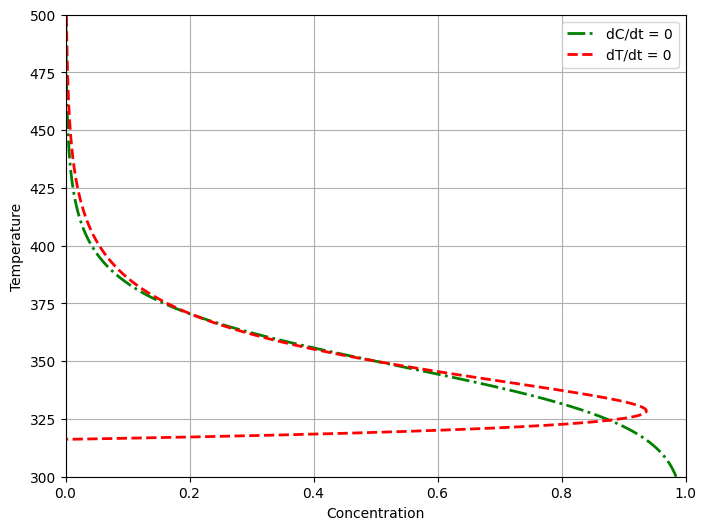

In [25]:
# plot nullclines
Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q   = 100.0     # Flowrate [L/min]
cAf = 1.0       # Inlet feed concentration [mol/L]
Tf  = 350.0     # Inlet feed temperature [K]

def plot_nullclines(ax, Tc=300.0):
    T = np.linspace(300.0, 500.0, 1000)
    df = pd.DataFrame({'T': T,
                       "dC/dt = 0": (q/V)*cAf/((q/V) + k(T)),
                       "dT/dt = 0": (rho*q*Cp*(Tf - T) + UA*(Tc - T))/(V*dHr*k(T))})
    df.plot(x = 1, y = 0, lw=2, ax=ax, xlabel="Concentration", ylabel="Temperature", style={"T":"g-."})
    df.plot(x = 2, y = 0, lw=2,ax=ax, grid=True, xlim=(0, 1), xlabel="Concentration", ylim = (300, 500), style={"T":"r--"})
    ax.legend(['dC/dt = 0','dT/dt = 0'])

fix, ax = plt.subplots(1, 1, figsize=(8, 6))
# Pass a single float value instead of the array defined in the global scope
plot_nullclines(ax, Tc=300.0)

## Phase Plane Analysis

The final analysis is display the simulation in both time and phase plane coordinates. The red circle is the initial point.

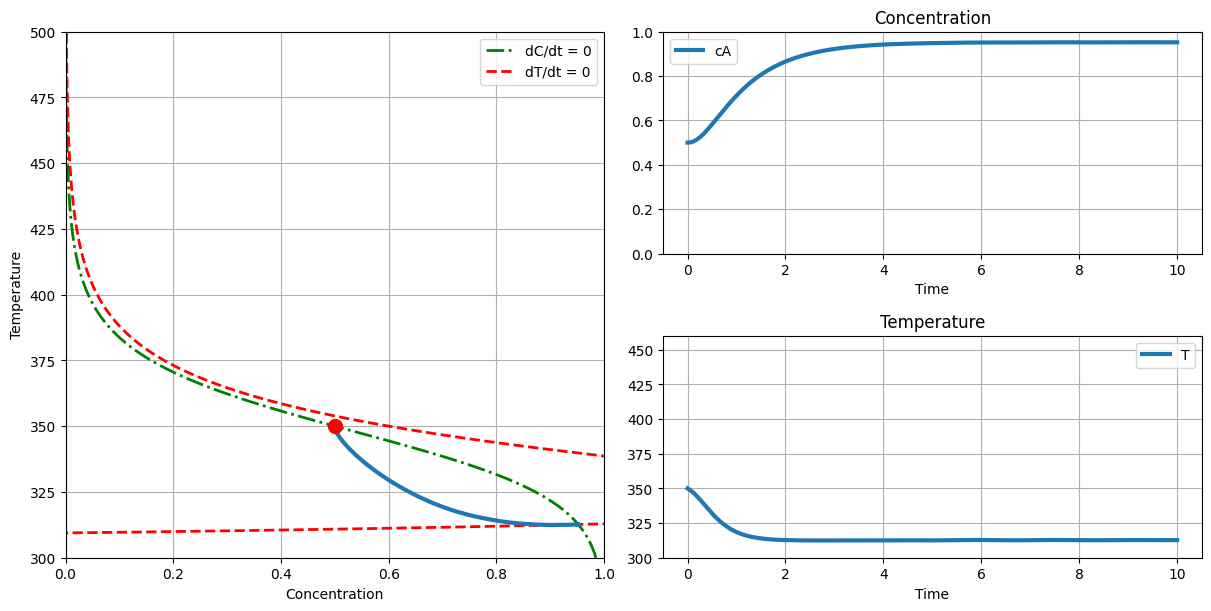

In [9]:
# set up figure window and axes
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

# simulate
t_final = 10
t_eval = np.linspace(0, t_final, 1001)
df = simulate_cstr(t_eval)

# add plots
plot_nullclines(ax1)
ax1.plot(df["cA"], df["T"], lw=3)
ax1.plot(df.loc[0, "cA"], df.loc[0, "T"], 'r.', ms=20)
df.plot(x=0, y="cA", ax=ax2, grid=True, ylim=(0, 1), title="Concentration", lw=3)
df.plot(x=0, y="T", ax=ax3, grid=True, ylim=(300, 460), title="Temperature", lw=3)
plt.close(fig)

def plot_phase(T_cooling, c_initial, T_initial):
    df = simulate_cstr(t_eval, T_cooling, c_initial, T_initial)
    T = np.linspace(300.0, 500.0, 1000)
    ax1.lines[1].set_xdata((rho*q*Cp*(Tf - T) + UA*(T_cooling - T))/(V*dHr*k(T)))
    ax1.lines[2].set_xdata(df["cA"])
    ax1.lines[2].set_ydata(df["T"])
    ax1.lines[3].set_xdata([c_initial])
    ax1.lines[3].set_ydata([T_initial])
    ax2.lines[0].set_ydata(df["cA"])
    ax3.lines[0].set_ydata(df["T"])
    display(fig)

# Uncomment the line below to run the interactive widget
# interact(plot_phase, T_cooling = (290.0, 310.0), c_initial = (0.0, 1.0, 0.01), T_initial = (300, 400));

plot_phase(T_cooling=290., c_initial=0.5, T_initial=350.)

## Activities

**1.** Adjust the cooling temperature over the range of values from 290K to 310K, identify the cooling water temperatures at which you observe a qualitative difference in system behavior. Try to identify the following behaviors:

* Stable steady state
* Oscillatory steady state
* The onset of a thermal runaway condition

Describe the behavior using the nullclines.


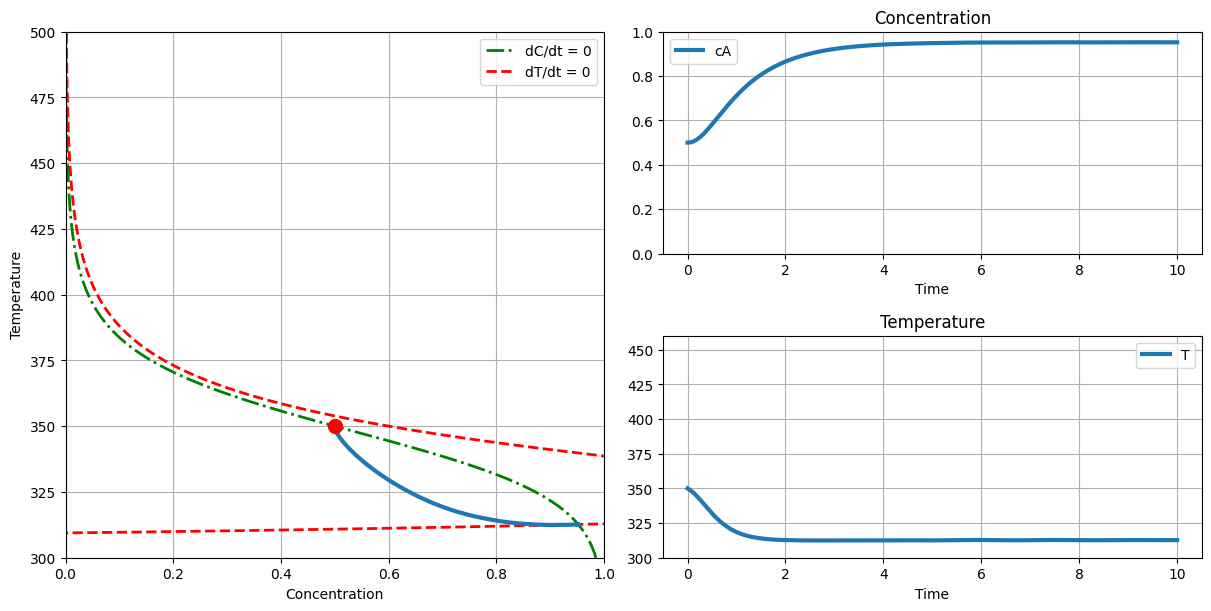

In [10]:
# stable steady state operation
plot_phase(T_cooling=290., c_initial=0.5, T_initial=350.)

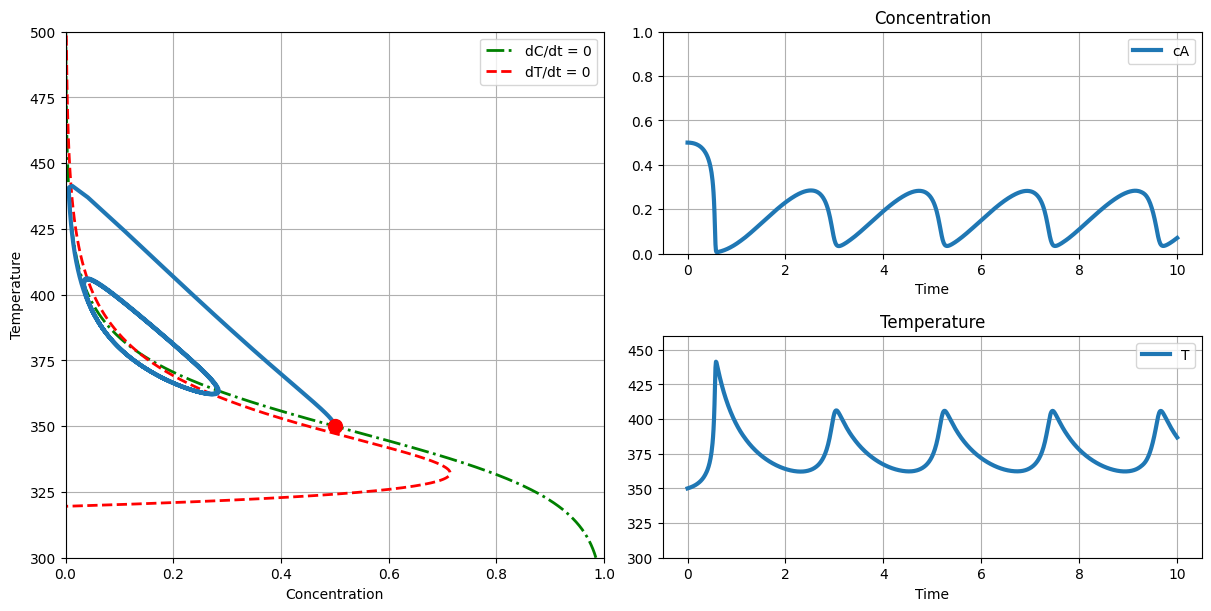

In [11]:
# oscillatory steady state operation
plot_phase(T_cooling=305., c_initial=0.5, T_initial=350.)

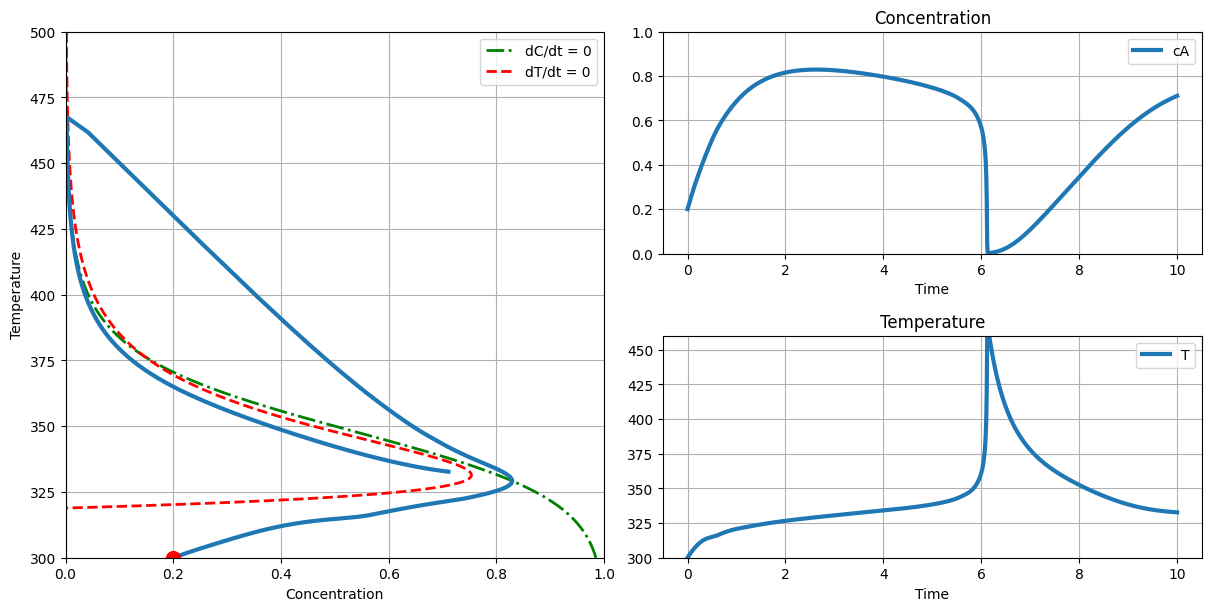

In [12]:
# onset of thermal runaway
plot_phase(T_cooling=304., c_initial=0.2, T_initial=300.)


**2.** Assume the reactor is start up with a tank of reactant feed with a concentration $c_A = 1$. What is the maximum initial temperature that would avoid thermal runaway during reactor startup?

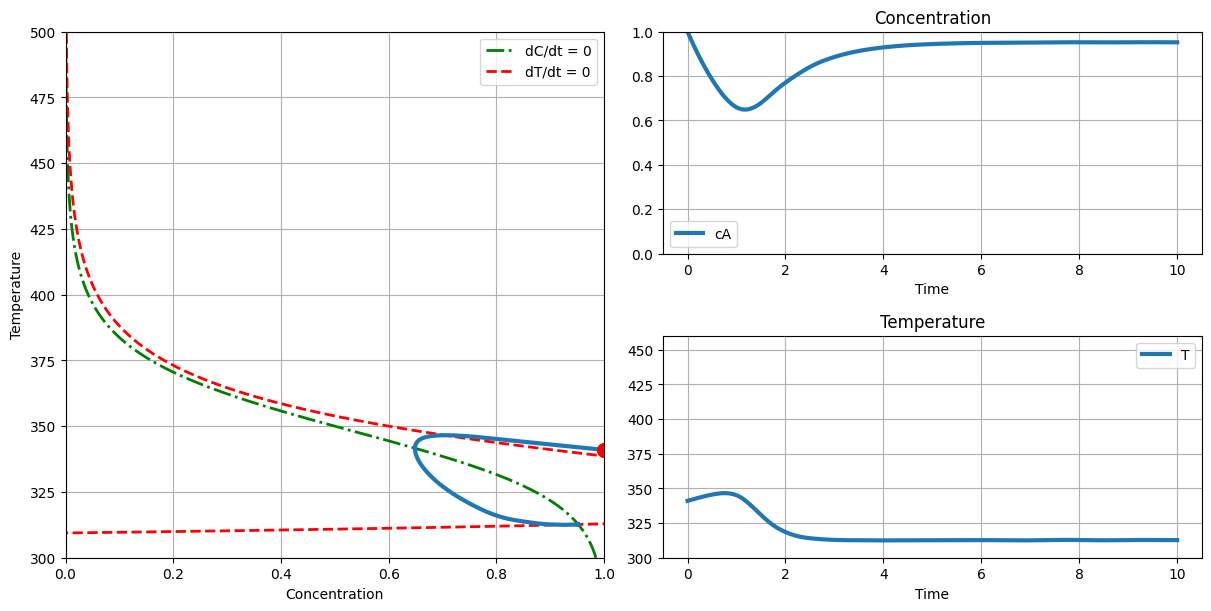

In [13]:
# no thermal runaway
plot_phase(T_cooling=290., c_initial=1.0, T_initial=341.)

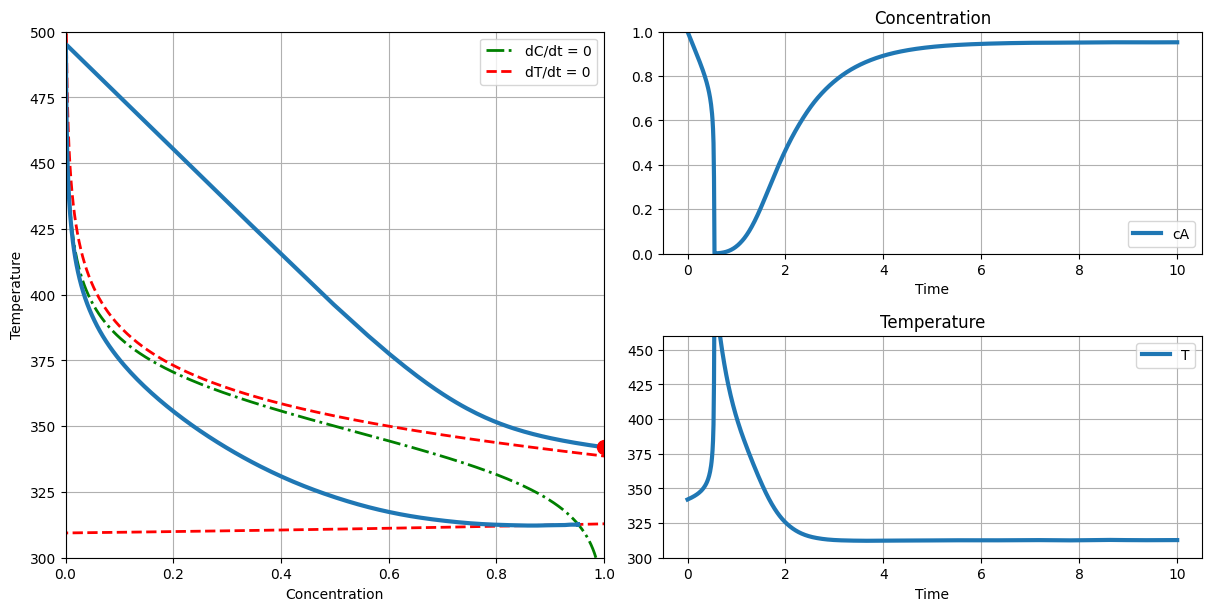

In [14]:
# with thermal runaway
plot_phase(T_cooling=290., c_initial=1.0, T_initial=342.)

## Steady-States

Let's now numerically compute the steady-state reactor concentration $\bar{c}_A$ and temperature $\bar{T}$ as a function of the coolant temperature.

First, we will (define again) a function to evaluate the RHS of the ODEs.

In [15]:
# function to evaluate RHS of ODEs
def deriv(t, y, Tc=310.):
    cA, T = y

    # Arrhenius rate expression
    k = k0*np.exp(-Ea/(R*T))

    # Concentration derivative
    dcAdt = (q/V)*(cAf - cA) - k*cA

    # Temperature derivative
    dTdt = (q/V)*(Tf - T) + (-dHr/rho/Cp)*k*cA + (UA/V/rho/Cp)*(Tc-T)
    return np.array([dcAdt, dTdt])

Next, we will use Newton's method, available in `scipy.optimize.root`, to numerically compute values of $\bar{c}_A$ and $\bar{T}$ at one coolant temperature.

In [16]:
from scipy.optimize import root
# Test calculation for steady-state at one coolant temperature
ode_func = lambda y_ : deriv(t=0.0, y=y_, Tc=300.)
sln = root(ode_func, [0.5, 350.])
y_bar = sln.x
print("cA = ", round(y_bar[0],2), "mol/L")
print("T = ", round(y_bar[1],2), "K")

cA =  0.5 mol/L
T =  350.08 K


Next, we will put our Newton's method code in a `for` loop. This will allow us to calculate the steady-state for many values of $T_c$.

Failed to converge at Tc =  303.5 , trying with failsafe initial guess


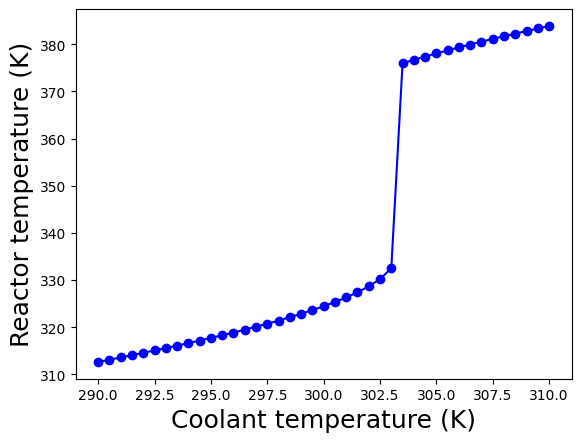

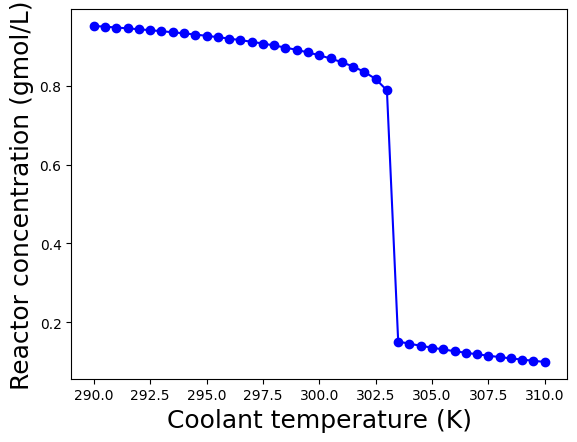

In [17]:
# Allocation arrays to store results
Tc = np.linspace(290, 310, 41)
T = np.zeros_like(Tc)
ca = np.zeros_like(Tc)

for i, Ti in enumerate(Tc):
    # Define new lambda function using the current value of Tc
    ode_func = lambda y_ : deriv(t=0.0, y=y_, Tc=Ti)

    y_default = [0.9, 310.]
    y_fail = [0.2, 370.]

    # Set initial guess for fsolve
    if i > 0:
        # Use previous solution as initial guess
        y0 = [ca[i-1], T[i-1]]
    else:
        # Default initial guess for first Tc value
        y0 = y_default.copy()
    sln = root(ode_func, y0)
    if not sln.success:
        print("Failed to converge at Tc = ", Ti,", trying with failsafe initial guess")

        # Try again with default initial guess
        sln = root(ode_func, y_fail)
        if not sln.success:
            print("Failed to converge at Tc = ", Ti," with failsafe initial guess")

    ca[i], T[i] = sln.x

plt.plot(Tc, T, marker='o', linestyle='-', color='b')
plt.xlabel('Coolant temperature (K)',fontsize=18)
plt.ylabel('Reactor temperature (K)',fontsize=18)
plt.show()

plt.plot(Tc, ca, marker='o', linestyle='-', color='b')
plt.xlabel('Coolant temperature (K)',fontsize=18)
plt.ylabel('Reactor concentration (gmol/L)',fontsize=18)
plt.show()

These plots show the calculated steady-states as a function of the coolant temperature $T_c$ assuming the other parameters are fixed to the values diven above in the table.

At coolant temperatures below 303.5 K, the steady-state is in the "low conversion region". Recall, $c_{A,f} = 1.0$ gmol/L, so the effluent concentration of $c_A \geq 0.8$ gmol/L means only a model amount of $A$ is converted into the desired products.

For coolant temperatures above 303.5 K, the steady-state shifts to the "high conversion region" with $c_{A} \leq 0.2$ gmol/L. In this region, a majority of species A fed into the reactor is converted into valuable products.

Notice the reactor temperature is much higher: $\geq 375$ K in the "high conversion region" compared to $\leq 335$ K in the "low conversion region". This is because the reaction is exothermic; in the "high conversion region", more reactant is consumed and thus more heat is released, which raises the reactor temperature. Recall, the reaction is also faster at higher temperatures. These two phenomena work together to produce the sudden shift between the "low conversion" and "high conversion" regions.


## Stability analysis

Next, we want to analyze the stability of the open-loop (i.e., no feedback control) system.

Recall, we previously learned how the eigenvalues of linear system tell us about the dynamic response. Recall the canonical state-space linear system:

$$
\dot{\mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u}, \qquad \mathbf{y} = \mathbf{C} \mathbf{x} + \mathbf{D} \mathbf{u}
$$

But we have a nonlinear system:

$$
\dot{\mathbf{x}} = \mathbf{f}(t, \mathbf{x}, \mathbf{u}), \qquad \mathbf{y} = \mathbf{h}(t, \mathbf{x}, \mathbf{u})
$$

To analyze stability, we are going to construct a linear approximation:

$$
\dot{\mathbf{x}} \approx \mathbf{A} \mathbf{x}
$$

For this example, we are going to consider $\mathbf{u} = 0$ and examine the eigenvalues if $\mathbf{A}$.

How to construct this linear approximation?

We will compute the Jacobian of the RHS of the ODEs:

$$
\mathbf{A} = \nabla_\mathbf{x} \mathbf{f}(t, \mathbf{x}, \mathbf{u})
$$

This Jacobian will be evaluated/computed at the steady-state we wish to analyze.

First, we will assemble a linear approximation to our ODE system using [finite difference code from CBE 20258](https://ndcbe.github.io/data-and-computing/notebooks/06/Newton-Raphson-Methods-for-Systems-of-Equations.html?#finite-difference-to-approximate-the-jacobian-matrix).

In [18]:
def Jacobian(f,x,delta = 1.0e-7):
    '''Approximate Jacobian using forward finite difference

    Args:
        f: vector-valued function
        x: point to build approximation J(x) around
        delta: finite difference step size

    Returns:
        J: square Jacobian matrix (approximation)

    Reference: CBE 20258, Notre Dame

    '''
    # Determine size
    N = x.size

    #Evaluate function f at x
    fx = f(x) #only need to evaluate this once

    # Make sure f is square (no. inputs = no. outputs)
    try:
        assert N == fx.size, "Your problem is not square!"
    except AssertionError:
        print("x = ",x)
        print("fx = ",fx)


    # Allocate empty matrix
    J = np.zeros((N,N))

    idelta = 1.0/delta #division is slower than multiplication
    x_perturbed = x.copy() #copy x to add delta

    # Loop over elements of x and columns of J
    for i in range(N):
        # Perturb (apply step) to element i of x
        x_perturbed[i] += delta

        # Approximate column in Jacobian
        col = (f(x_perturbed) - fx) * idelta

        # Reset element of x
        x_perturbed[i] = x[i]

        # Save results
        J[:,i] = col
    # end for loop
    return J

y0 = [ca[0], T[0]]
ode_jac = Jacobian(lambda y : deriv(0.0, y, Tc=Tc[0]), np.array(y0))
print("A approximation = \n",ode_jac)

A approximation = 
 [[-1.05041791e+00 -4.29658087e-03]
 [ 1.05476802e+01 -2.19318466e+00]]


Next, we will loop over the above calculated steady-states. At each steady-state, we will assemble the linearization and then compute the eigenvalues.

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2029766165.py:16: SyntaxWarning: invalid escape sequence '\l'
  ax1.plot(Tc,np.real(evals[:,0]),label="real($\lambda_1$)",color="blue",linestyle="-",linewidth=2)
/tmp/ipython-input-2029766165.py:17: SyntaxWarning: invalid escape sequence '\l'
  ax1.plot(Tc,np.real(evals[:,1]),label="real($\lambda_2$)",color="blue",linestyle="--",linewidth=2)
/tmp/ipython-input-2029766165.py:24: SyntaxWarning: invalid escape sequence '\l'
  ax2.plot(Tc,np.imag(evals[:,0]),label="imag($\lambda_1$)",color='red',linestyle="-",linewidth=2)
/tmp/ipython-input-2029766165.py:25: SyntaxWarnin

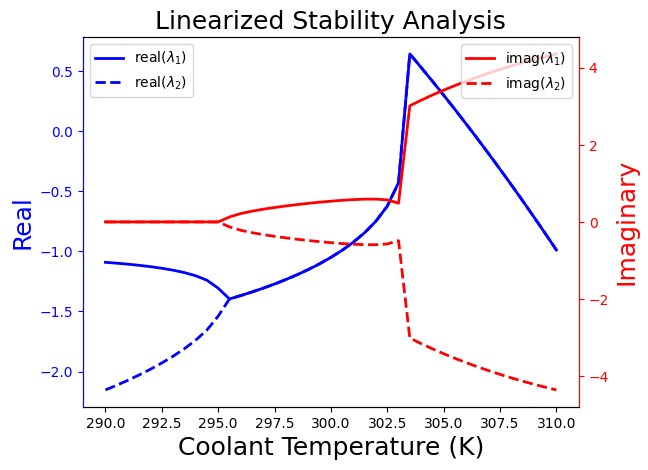

In [19]:
# Perform sensitivity analysis of eigenvalues to Tc

evals = np.zeros((len(Tc),2),dtype = complex)

for i in range(len(Tc)):

    # Construct Jacobian
    y0 = [ca[i], T[i]]
    ode_jac = Jacobian(lambda y : deriv(0.0, y, Tc=Tc[i]), np.array(y0))

    # Compute eigenvalues
    evals[i,:] = np.linalg.eigvals(ode_jac)

fig, ax1 = plt.subplots()

ax1.plot(Tc,np.real(evals[:,0]),label="real($\lambda_1$)",color="blue",linestyle="-",linewidth=2)
ax1.plot(Tc,np.real(evals[:,1]),label="real($\lambda_2$)",color="blue",linestyle="--",linewidth=2)
ax1.set_ylabel('Real', color='blue',fontsize=18)
ax1.set_xlabel('Coolant Temperature (K)',fontsize=18)
ax1.tick_params(axis='y', color='blue', labelcolor='blue')
ax1.set_title('Linearized Stability Analysis',fontsize=18)
plt.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(Tc,np.imag(evals[:,0]),label="imag($\lambda_1$)",color='red',linestyle="-",linewidth=2)
ax2.plot(Tc,np.imag(evals[:,1]),label="imag($\lambda_2$)",color='red',linestyle="--",linewidth=2)
ax2.set_ylabel('Imaginary', color='red',fontsize=18)
ax2.tick_params(axis='y', color='red', labelcolor='red')
ax2.spines['right'].set_color('red')
ax2.spines['left'].set_color('blue')
plt.legend(loc='upper right')
plt.show()

In this plot, we see four distinct regions from left to right:
* **Stable** because real($\lambda$) $\leq 0$ and **non-oscillatory** because imag($\lambda$) = 0
* **Stable** and **oscillatory** because imag($\lambda$) $\neq$ 0
* **Unstable** because real($\lambda$) $\geq 0$ and **oscillatory**
* **Stable** with fast **oscillations** because abs(imag($\lambda$)) are large

From an economic perspective, we want to operate at a steady-state in the "high conversion region", which means an elevated reactor temperature. However, from a safety perspective, this is challenging because the system concentration and temperatures oscillate in this region. Moreover, there is an intermediate region between low and high coolant temperatures in which the reactor is subject to thermal run away! During the next few weeks, we will discuss how to design feedback control systems that enable operating in the economically preferred "high conversion region" while mitigating these safety issues.

Compare this plot to the analysis of our second order system (mass-spring-damper example). Nonlinear systems such as this simple exothermic reactor a much more complicated! This is why controls and dynamical systems are so interesting in chemical and biomolecular engineering.

## Take Away Messages

* Many chemical and biomolecular engineering dynamical systems are nonlinear.
* We derived the simple continous stirred tank reactor (CSTR) model from a dynamic mass and energy balance.
* The simple exothermic CSTR model is nonlinear with respect to temperature and subject to thermal run away to high conversions.
* We used nullclines and Newton's method to compute steady-states as a function of the manipulated variable (coolant temperature).
* We examined the eigendecomposition of linearize system to understand the system response, e.g., stable versus unstable, oscillatory versus non-oscillatory, around the steady-states.
* During the next few weeks, we will design feedback control systems that allow us to safely operate at desired steady-state operating points (e.g., high conversion) while mitigating undersiable aspects of their open-loop steady-state response (e.g., unstable, oscillatory).
* This example illustrates why control of chemical and biomolecular systems, which are often nonlinear, is much more interesting (in the instructors' opinions) than many mechanical or electrical systems, which are often linear.
* In the next section,  we will look at a biological example.